In [25]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.io import decode_image
import torchvision.models as models
from torchvision.ops import generalized_box_iou_loss
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from tqdm.auto import tqdm
import requests
import zipfile
import pathlib
from pathlib import Path
import shutil
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from typing import Tuple, Dict, List
import sys
from timeit import default_timer as timer

# %load_ext autoreload
# %autoreload 1
# %aimport CarImageClass
import CarImageClass

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'laptop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"D:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

IMG_SIZE = 224

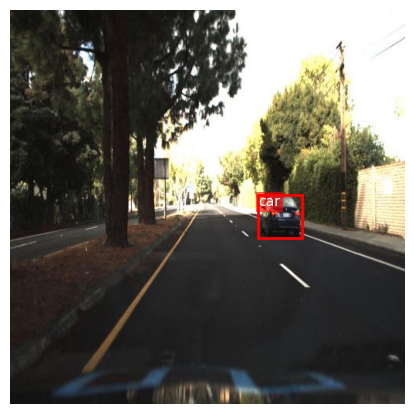

In [26]:
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=None, file_pct=0.5)

train_data.show_with_box(index=1, color='r', label=True)

In [27]:
class SingleBoxResNet18DetCls(nn.Module):
    def __init__(self, num_classes: int, img_hw: tuple[int,int], pretrained: bool=True):
        super().__init__()
        H, W = img_hw                      # e.g. (224,224); do NOT pass a scalar
        self.img_h, self.img_w = H, W
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        in_feats = m.fc.in_features
        m.fc = nn.Identity()               # expose penultimate features
        self.backbone = m

        # two small heads
        self.head_box = nn.Sequential(
            nn.Linear(in_feats, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 4)
        )
        self.head_cls = nn.Sequential(
            nn.Linear(in_feats, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)    # raw logits (no softmax)
        )


    def forward(self, x):
        feat = self.backbone(x)                    # (B, in_feats)
        box_raw = self.head_box(feat)              # (B,4)
        cls_logits = self.head_cls(feat)           # (B,C)

        # keep raw logits for CE; postprocess boxes
        # map to [0,1] without hard saturation; clamp at the end
        box01 = box_raw.sigmoid()              # (B,4) in [0,1]
        x1, y1, x2, y2 = box01.unbind(-1)
        x_min = torch.minimum(x1, x2) * self.img_w
        y_min = torch.minimum(y1, y2) * self.img_h
        x_max = torch.maximum(x1, x2) * self.img_w
        y_max = torch.maximum(y1, y2) * self.img_h
        boxes = torch.stack([x_min, y_min, x_max, y_max], dim=-1)
        

        # final clamp to image bounds
        eps = 1e-4
        x1 = boxes[..., 0].clamp(0, self.img_w - eps)
        y1 = boxes[..., 1].clamp(0, self.img_h - eps)
        x2 = boxes[..., 2].clamp(0, self.img_w - eps)
        y2 = boxes[..., 3].clamp(0, self.img_h - eps)
        boxes = torch.stack([x1, y1, x2, y2], dim=-1)
        
        return {"boxes": boxes, "logits": cls_logits}
    

In [28]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn_bb: torch.nn.Module,
               loss_fn_class: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    # put model in train mode
    model.train()

    # train loss
    train_loss_bb, train_loss_class, train_loss = 0, 0, 0

    # loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        for key in y.keys():
            y[key] = y[key].to(device)

        # forward pass
        # B, _, H, W = X.shape
        y_pred = model(X)

        # calculate loss
        loss_bb = loss_fn_bb(y_pred['boxes'].squeeze() / IMG_SIZE, y['boxes'].squeeze() / IMG_SIZE)
        train_loss_bb += loss_bb.item()

        # 0 is 'background' or no object but that is not present in dataset, shift labels down by 1
        loss_class = loss_fn_class(y_pred['logits'], y['labels'].squeeze() - 1)
        train_loss_class += loss_class.item()

        train_loss += loss_bb + loss_class # a weighted combo can be taken later

        # Optimizer zero grad
        optimizer.zero_grad(set_to_none=True)

        # loss backward
        loss = loss_bb + loss_class
        loss.backward()

        # optimizer step
        optimizer.step()


    train_loss = train_loss / len(dataloader)
    train_loss_bb = train_loss_bb / len(dataloader)
    train_loss_class = train_loss_class / len(dataloader)
    return train_loss, {'train box loss': train_loss_bb, 'train classification loss': train_loss_class}

############################################################

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn_bb: torch.nn.Module,
              loss_fn_class: torch.nn.Module,
              device=device):
    # put model in eval mode
    model.eval()

    # test loss, test acc
    test_loss_bb, test_loss_class, test_loss = 0, 0, 0

    # turn on inference mode
    with torch.inference_mode():
        # loop through dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to device
            X = X.to(device)
            for key in y.keys():
                y[key] = y[key].to(device)

            # forward pass
            # B, _, H, W = X.shape
            test_pred = model(X)

            # calculate loss
            loss_bb = loss_fn_bb(test_pred['boxes'].squeeze() / IMG_SIZE, y['boxes'].squeeze() / IMG_SIZE)
            test_loss_bb += loss_bb.item()

            loss_class = loss_fn_class(test_pred['logits'], y['labels'].squeeze() - 1)
            test_loss_class += loss_class.item()

            test_loss += loss_bb + loss_class # a weighted combo can be taken later

    
    test_loss = test_loss / len(dataloader)
    test_loss_bb = test_loss_bb / len(dataloader)
    test_loss_class = test_loss_class / len(dataloader)
    return test_loss, {'test box loss': test_loss_bb, 'test classification loss': test_loss_class}

############################################################

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          loss_fn_bb: torch.nn.Module,
          loss_fn_class: torch.nn.Module,
          epochs: int = 5,
          device=device):
    
    # create results dictionary
    results = {"train_loss": [],
               "train_loss_bb": [],
               "train_loss_class": [],
               "test_loss": [],
               "test_loss_bb": [],
               "test_loss_class": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_dict = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn_bb=loss_fn_bb,
                                loss_fn_class=loss_fn_class,
                                optimizer=optimizer,
                                device=device)
        
        test_loss, test_dict = test_step(model=model,
                                dataloader=test_dataloader,
                                loss_fn_bb=loss_fn_bb,
                                loss_fn_class=loss_fn_class,
                                device=device)
        
        if scheduler is not None:
            scheduler.step()
        
        # print(f"Epoch: {epoch}  |  Train loss: {train_loss:.4f}  |  Train box loss: {train_dict['train box loss']:.4f}  |  Train class loss: {train_dict['train classification loss']:.4f}")
        # print(f"Epoch: {epoch}  |  Test loss: {test_loss:.4f}  |  Test box loss: {test_dict['test box loss']:.4f}  |  Test class loss: {test_dict['test classification loss']:.4f}")
        print(f"Epoch: {epoch}  |  Train box loss: {train_dict['train box loss']:.4f}  |  Train class loss: {train_dict['train classification loss']:.4f}  |  Test box loss: {test_dict['test box loss']:.4f}  |  Test class loss: {test_dict['test classification loss']:.4f}")

        # update results dictionary
        results['train_loss'].append(train_loss)
        results['train_loss_bb'].append(train_dict['train box loss'])
        results['train_loss_class'].append(train_dict['train classification loss'])
        results['test_loss'].append(test_loss)
        results['test_loss_bb'].append(test_dict['test box loss'])
        results['test_loss_class'].append(test_dict['test classification loss'])

    # return results
    return results

In [29]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((IMG_SIZE, IMG_SIZE)),                        # pick a fixed size for batching
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# training/testing data
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=train_tfms, file_pct=0.25)
test_data = CarImageClass.ImageClass(targ_dir=test_path_oo, transform=test_tfms, file_pct=0.25)


BATCH_SIZE = 16
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              #num_workers=NUM_WORKERS,
                              )

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             #num_workers=NUM_WORKERS,
                             )

# number of epochs
NUM_EPOCHS = 36

# model instantiation
model_0 = SingleBoxResNet18DetCls(3, (IMG_SIZE, IMG_SIZE)).to(device)

# create weights for cross entropy loss
counts = torch.zeros(len(train_data.classes))
i = 0
for name in train_data.classes:
    counts[i] = train_data.annotate_df['class'].value_counts()[name]
    i +=1

weights = (1.0 / counts.clamp_min(1).sqrt())
weights = weights / weights.mean()

# setup loss function
loss_fn_bb = nn.L1Loss()
loss_fn_class = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.AdamW(params=model_0.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

# start timer
start_time = timer()

# train model 0

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn_bb=loss_fn_bb,
                        loss_fn_class=loss_fn_class,
                        epochs=NUM_EPOCHS)

# end timer and print
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 0  |  Train box loss: 0.1250  |  Train class loss: 1.1842  |  Test box loss: 0.4156  |  Test class loss: 3.6268
Epoch: 1  |  Train box loss: 0.1152  |  Train class loss: 0.6759  |  Test box loss: 0.1142  |  Test class loss: 0.5150
Epoch: 2  |  Train box loss: 0.1116  |  Train class loss: 0.6134  |  Test box loss: 0.1095  |  Test class loss: 0.4163
Epoch: 3  |  Train box loss: 0.1119  |  Train class loss: 0.5470  |  Test box loss: 0.1072  |  Test class loss: 0.4290
Epoch: 4  |  Train box loss: 0.1099  |  Train class loss: 0.4198  |  Test box loss: 0.1057  |  Test class loss: 0.3846
Epoch: 5  |  Train box loss: 0.1109  |  Train class loss: 0.3757  |  Test box loss: 0.1097  |  Test class loss: 0.3720
Epoch: 6  |  Train box loss: 0.1089  |  Train class loss: 0.3527  |  Test box loss: 0.1107  |  Test class loss: 0.3093
Epoch: 7  |  Train box loss: 0.1101  |  Train class loss: 0.3833  |  Test box loss: 0.1103  |  Test class loss: 0.2880
Epoch: 8  |  Train box loss: 0.1097  |  Train cl

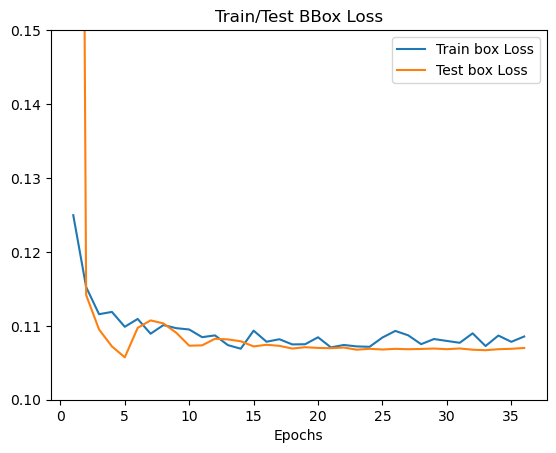

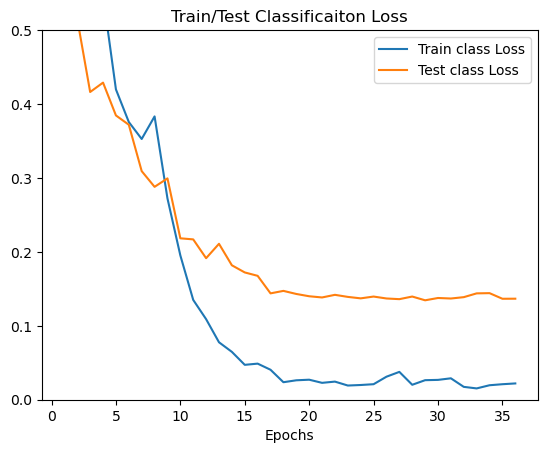

In [39]:
plt.plot(range(1, 1+NUM_EPOCHS), model_0_results["train_loss_bb"], label="Train box Loss")
plt.plot(range(1, 1+NUM_EPOCHS), model_0_results["test_loss_bb"], label="Test box Loss")
plt.title("Train/Test BBox Loss")
plt.xlabel("Epochs")
plt.legend()
plt.ylim(0.1,0.15)

plt.show()


plt.plot(range(1, 1+NUM_EPOCHS), model_0_results["train_loss_class"], label="Train class Loss")
plt.plot(range(1, 1+NUM_EPOCHS), model_0_results["test_loss_class"], label="Test class Loss")
plt.title("Train/Test Classificaiton Loss")
plt.xlabel("Epochs")
plt.legend()
plt.ylim(0,0.5)

plt.show()

In [42]:
dl = next(iter(train_dataloader))

dl[1]['labels'] - 1

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

In [43]:
model_0.eval()
with torch.inference_mode():
    preds = model_0(dl[0])

In [44]:
preds['logits'].argmax(dim=-1)

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])